
### Few remarks:
1. we have shown that the most efficient sparsity is a time window of consequtive voltage images of MEA recordings.
2. It is important to note the measurement is applied on MEA electrodes and remain constant for all of the measurement time. This is a limitation applied by aquisition.

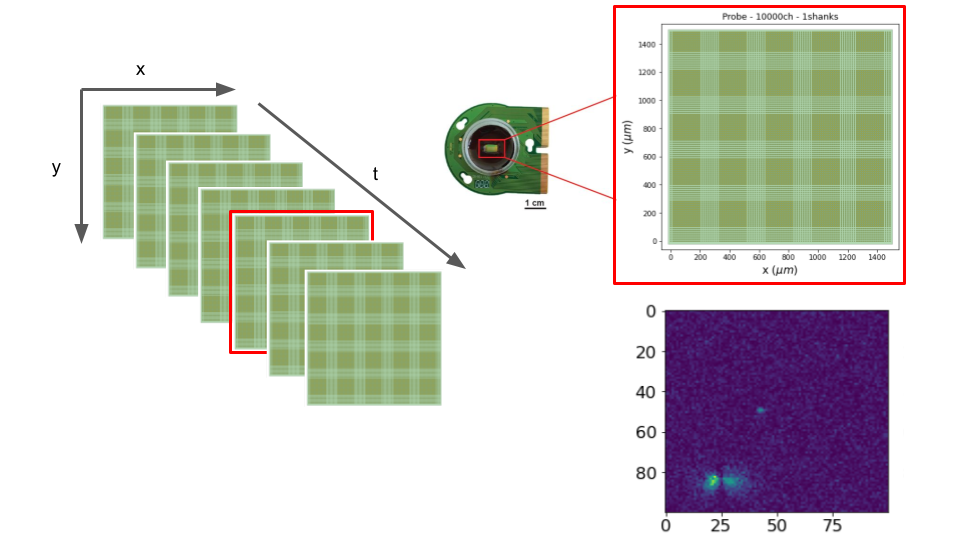

In [1]:
import matplotlib.pyplot as plt
size=15
parameters = {'axes.labelsize': size, 'axes.titlesize': size, 'figure.titlesize': size,
              'xtick.labelsize': size, 'ytick.labelsize': size, 'legend.fontsize': 15,
              'legend.title_fontsize': 15, 'figure.figsize':(16,4)}
plt.rcParams.update(parameters)
import seaborn as sns
import numpy as np
import tensorflow as tf
import seaborn as sn
import h5py
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, Lars
from scipy.fftpack import dct, idct
from scipy import linalg
from scipy import signal
import pywt
import matplotlib.animation as animation
from IPython.display import HTML

2022-07-24 20:38:49.496925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-24 20:38:49.496950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#given a liest of numpy array v 
def make_gif(v):
#    plt.rcParams['figure.figsize'] = [8,6]
    plt.rc('animation', html='html5')
    fig = plt.figure(figsize=(6,4))
    s = abs(v[0].reshape(100,100))
    im = plt.imshow(s, animated=True)

    def updatefig(i):
        im.set_array(abs(v[i].reshape(100,100)))
        return im,
    anim = animation.FuncAnimation(fig, updatefig,
                                   frames=len(v),interval=200,
                                   blit=True)
#    HTML(anim.to_html5_video())
    plt.close()
    return anim
#     writervideo = animation.FFMpegWriter(fps=4)
#     anim.save(str(name)+'.gif', writer=writervideo)
#     plt.close()

def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y

# gives the number of measurements and probability that guarantees RIP
def rip(k1, delta, l, k):  
    #k_star
    k_star = 2/(1-np.log(2))
    # k2
    k2 = delta**2 / (2*k_star) - 1 / (k1*np.log(42*np.e / delta))
    # number of measurements
    nm = int( round(k1*k*np.log(l/k) ) )
    # probability of RIP satisfaction
    p = 1 - 2*np.exp(k2*nm)
    return nm, p

class OMP(OrthogonalMatchingPursuit):
    def __init__(self, k_sparse, M, A):
        super(OMP, self).__init__()
        self.M= M
        self.A= A
        self.omp= OrthogonalMatchingPursuit(n_nonzero_coefs=k_sparse, normalize=False)

    def __call__(self, v):
        self.y= np.dot(self.M, v)
        self.omp.fit(self.A, self.y)
        return self.omp.coef_
    
class OMPCV(OrthogonalMatchingPursuitCV):
    def __init__(self, M, A):
        super(OMPCV, self).__init__()
        self.M= M
        self.A= A
        self.ompcv= OrthogonalMatchingPursuit(normalize=False)

    def __call__(self, v):
        self.y= np.dot(self.M, v)
        self.ompcv.fit(self.A, self.y)
        return self.ompcv.coef_
    
class LARS(Lars):
    def __init__(self, k_sparse, M, A):
        super(LARS, self).__init__()
        self.M= M
        self.A= A
        self.lars= Lars(n_nonzero_coefs=k_sparse, normalize=False)

    def __call__(self, v):
        self.y= np.dot(self.M, v)
        self.lars.fit(self.A, self.y)
        return self.lars.coef_
    
def hard_thresh(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    x[j] = 0
    return x

def iht(y, A, v, k_sparse, iteration):
    x=np.zeros(len(v))
    for i in range(iteration):
        xn = x + A.T.dot(y - A.dot(x))
        x = hard_thresh(xn, k_sparse)
    return x

def soft_thresh(x, l1):
    return np.sign(x) * np.maximum(np.abs(x) - l1, 0.)

def ist(A, y, l1, maxit):
    x = np.zeros(A.shape[1])
    L = linalg.norm(A, ord=2) **2  # Lipschitz constant
    for _ in range(maxit):
        r= y - A.dot(x)
        z= x + A.T.dot(r)/L
        x= soft_thresh(z, l1 / L)
    return x

def fist(A, y, l1, maxit):
    x = np.zeros(A.shape[1])
    t = 1
    z = x.copy()
    L = linalg.norm(A, ord=2) **2
    for _ in range(maxit):
        xold = x.copy()
        r= y - A.dot(z)
        z = z + np.dot(A.T, r) / L
        x = soft_thresh(z, l1 / L)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
    return x

def amp(A, y, l1, maxit):
    x= np.zeros(A.shape[1])
    z= y
    for _ in range(maxit):
        theta = l1 * np.sqrt(linalg.norm(z)**2/len(y)) # alpha*tau
        s= x + np.dot(A.T,z)
        x= soft_thresh(s, theta)
        # update with osenger
        b= linalg.norm(x,0)/len(y)
        z= y - np.dot(A,x) + b*z
    return x

### reade data and build dataset:

In [3]:
#path = 'data/MEA10*10/recgen_cell_10/0.h5'
path = 'data/MEA100*100/recgen.h5'
with h5py.File(path,'r') as f:
    print(list(f.keys()))
    
recording = h5py.File(path,'r').get('recordings')

['channel_positions', 'info', 'original_templates', 'recordings', 'spike_traces', 'spiketrains', 'template_celltypes', 'template_ids', 'template_locations', 'template_rotations', 'templates', 'timestamps', 'voltage_peaks']


In [4]:
class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        with h5py.File(self.file, 'r') as hf:
            for im in hf['recordings']:
                yield im

In [5]:
nex, ney= 100, 100
ds = tf.data.Dataset.from_generator(generator(path),
                                    output_types=(tf.float32),
                                    output_shapes=(nex*ney,))
ds

2022-07-24 20:40:14.072027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-24 20:40:14.072061: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-24 20:40:14.072084: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bs-hierlemann11.ethz.ch): /proc/driver/nvidia/version does not exist
2022-07-24 20:40:14.072863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<FlatMapDataset element_spec=TensorSpec(shape=(10000,), dtype=tf.float32, name=None)>

In [6]:
v=[]
for e in ds.skip(30).take(40):
    v.append(e.numpy())

In [7]:
make_gif(v)

### With 1% of coefficients on F space we have a better sorting result

In [8]:
vr=[]
for x in v:
    vs= idct(make_sparse(dct(x,norm='ortho'), nex*ney//100),norm='ortho')
    vr.append(vs.reshape(100,100))

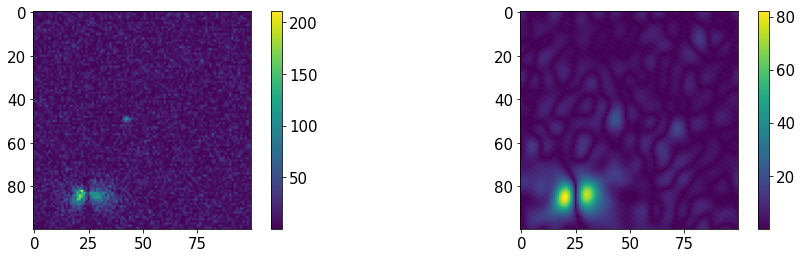

In [9]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(100,100)))
plt.colorbar()

In [10]:
make_gif(vr)

### check RIP, get number of measurements, build representation and measurement matrices

In [11]:
k1=1
delta= .9
l= nex*ney
k= l//20
nm, p= rip(k1, delta, l, k)

print('number of measurements= %s (%s %%)'%(nm, 100*nm/l))
print('RIP probability= ', p)

number of measurements= 1498 (14.98 %)
RIP probability=  1.0


In [92]:
idf= idct(np.eye(nex*ney), norm='ortho')
Mg= np.random.normal(0.0, 1/np.sqrt(nm), (nm, l))
Mb= np.random.binomial(1, .15, size=(nm,l))
Mi= np.diag(np.random.binomial(1, .15, size=(l,)))
M=Mi
A= np.dot(M, idf)
k_sparse= l//100
print('Sparsity= %s (%s %%)'%(k_sparse, 100*k_sparse/l))

Sparsity= 100 (1.0 %)


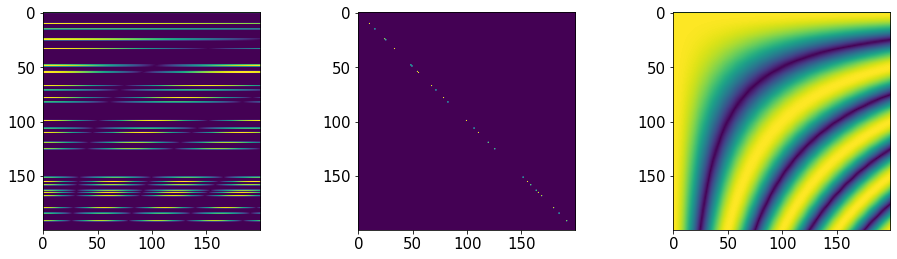

In [93]:
plt.subplot(131)
plt.imshow(abs(A[:200,:200]))
plt.subplot(132)
plt.imshow(abs(M[:200,:200]))
plt.subplot(133)
plt.imshow(abs(idf[:200,:200]))

### Orthogonal Matching Pursuit

In [94]:
omp = OMP(k_sparse, M, A)
vr=[]
for x in v:
    vs = omp(x)
    vr.append(dct(vs,norm='ortho'))

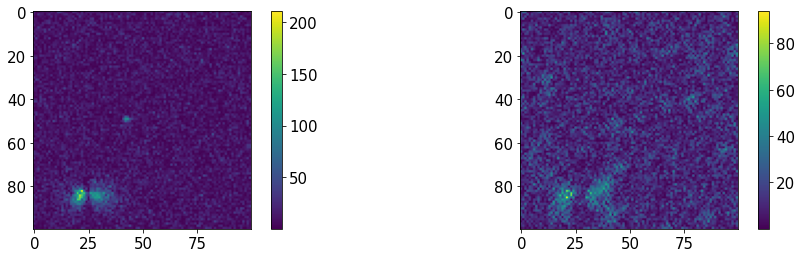

In [95]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.colorbar()

In [97]:
ompcv = OMPCV(M, A)
vr=[]
for x in v:
    vs = ompcv(x)
    vr.append(dct(vs,norm='ortho'))


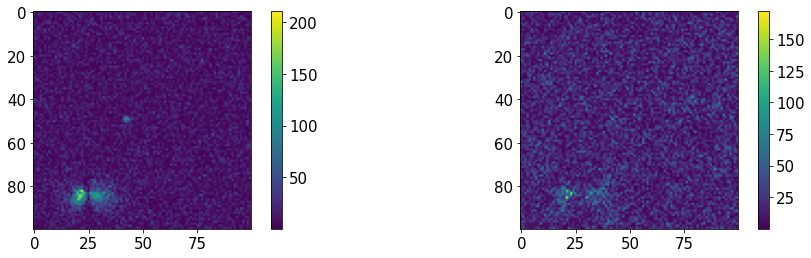

In [98]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(100,100)))
plt.colorbar()

### Least Angle Regression

In [99]:
lars = LARS(k_sparse, M, A)
vr=[]
for x in v:
    vs = lars(x)
    vr.append(dct(vs,norm='ortho'))

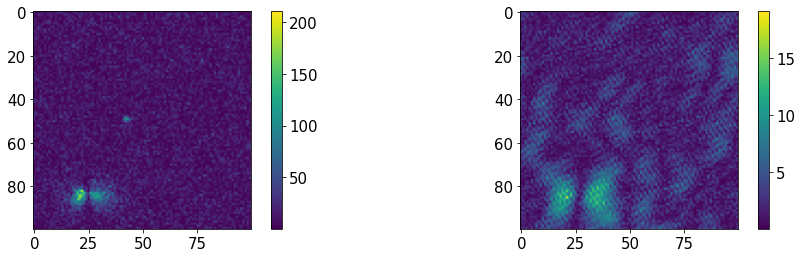

In [100]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(100,100)))
plt.colorbar()

### Itereative Hard Thresholding

In [101]:
ks = nex*ney//100
print('Sparsity= %s (%s %%)'%(ks, 100*ks/l))

it=1000
vr=[]
for x in v:
    y= np.dot(M, x)
    vs= iht(y,A,x,ks, it)
    vr.append(dct(vs,norm='ortho'))

Sparsity= 100 (1.0 %)


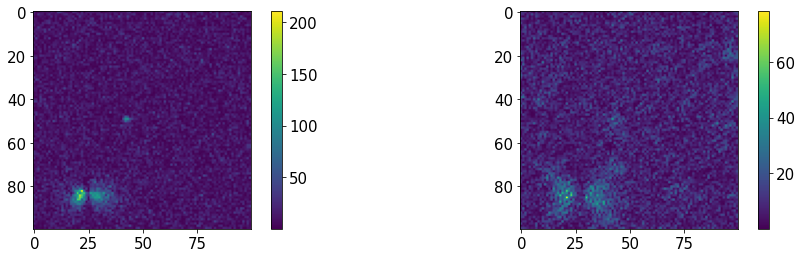

In [102]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(100,100)))
plt.colorbar()

### Iterative Soft Thresholding

In [103]:
l1 = 2  # regularization parameter
maxit = 1000
vr=[]
for x in v:
    y= np.dot(M, x)
    vs= ist(A, y, l1, maxit)
    vr.append(dct(vs,norm='ortho'))

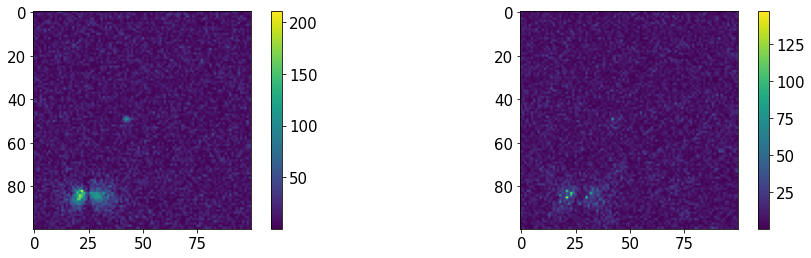

In [104]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(100,100)))
plt.colorbar()

In [105]:
make_gif(vr)

### Fast IST

In [106]:
l1 = 2  # regularization parameter
maxit = 1000
vr=[]
for x in v:
    y= np.dot(M, x)
    vs= fist(A, y, l1, maxit)
    vr.append(dct(vs,norm='ortho'))

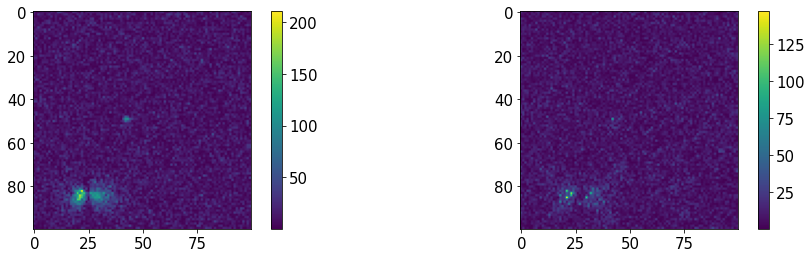

In [107]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(100,100)))
plt.colorbar()

In [108]:
make_gif(vr)

### Approximate Message Passing

In [109]:
l1 = 2  # regularization parameter
maxit = 1000
vr=[]
for x in v:
    y= np.dot(M, x)
    vs= amp(A, y, l1, maxit)
    vr.append(dct(vs,norm='ortho'))

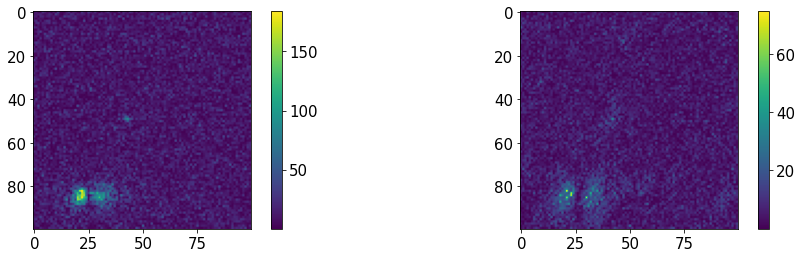

In [110]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[6].reshape(100,100)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[6].reshape(100,100)))
plt.colorbar()

In [111]:
make_gif(vr)